In [1]:
from tqdm import tqdm
import numpy as np
import queue
import cv2
import os

def getListFiles(path):
    ret = []
    for root, dirs, files in os.walk(path):  
        for filespath in files:
            ret.append(os.path.join(root,filespath)) 
    return ret

def get_images_labels():
    operators = ['plus', 'sub', 'mul', 'div', '(', ')']
    images = None
    labels = None
    for i, op in enumerate(operators):
        image_file_list = getListFiles('./cfs/' + op + '/')
        print('正在载入 ' + op + ' 运算符...')
        for filename in tqdm(image_file_list):
            image = cv2.imread(filename, 2)
            if image.shape != (28, 28):
                image = cv2.resize(image, (28, 28))
            image = np.resize(image, (1, 28 * 28))
            image = (255 - image) / 255
            label = np.zeros((1, 10 + len(operators)))
            label[0][10 + i] = 1
            if images is None:
                images = image
                labels = label
            else:
                images = np.r_[images, image]
                labels = np.r_[labels, label]
    return images, labels

op_images, op_labels = get_images_labels()
op_images = op_images.reshape(-1,28,28)

正在载入 plus 运算符...


100%|██████████| 5059/5059 [00:21<00:00, 230.02it/s]


正在载入 sub 运算符...


100%|██████████| 6500/6500 [01:20<00:00, 81.24it/s]


正在载入 mul 运算符...


100%|██████████| 5102/5102 [01:42<00:00, 49.97it/s]


正在载入 div 运算符...


100%|██████████| 4234/4234 [01:51<00:00, 37.97it/s]


正在载入 ( 运算符...


100%|██████████| 6500/6500 [03:39<00:00, 29.56it/s]


正在载入 ) 运算符...


100%|██████████| 6500/6500 [04:40<00:00, 23.19it/s]


In [2]:
from keras.datasets import mnist
from matplotlib import pyplot
import numpy as np
(trainX, trainY), (testX, testY) = mnist.load_data()

trainX = trainX.astype("float32")
testX = testX.astype("float32")
trainX = trainX/255.0
testX = testX/255.0

from tensorflow.keras.utils import to_categorical
trainY = to_categorical(trainY, 16)
testY = to_categorical(testY, 16)

In [3]:
dataset   = np.vstack((op_images, trainX, testX))
datalabel = np.vstack((op_labels, trainY, testY))

dataset = dataset.reshape(-1,28,28,1)
print('所有训练数据：',dataset.shape)
print('所有标签数据：',datalabel.shape)

所有训练数据： (103895, 28, 28, 1)
所有标签数据： (103895, 16)


In [4]:
from sklearn.model_selection import train_test_split

trainX, testX, trainY, testY = train_test_split(dataset,datalabel,test_size=0.1, random_state=0)
print('训练数据：',trainX.shape, trainY.shape)
print('测试数据：',testX.shape, testY.shape)

训练数据： (93505, 28, 28, 1) (93505, 16)
测试数据： (10390, 28, 28, 1) (10390, 16)


In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

model = Sequential()
model.add(Conv2D(28, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(28, (3, 3), activation='relu'))
model.add(Conv2D(28, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(16,  activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 28)        280       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 28)        7084      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 28)        7084      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 28)        0         
_________________________________________________________________
flatten (Flatten)            (None, 3388)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               867584    
_________________________________________________________________
dense_1 (Dense)              (None, 16)                4

In [6]:
model.fit(trainX, trainY ,batch_size=64 ,epochs = 10 ,verbose=1,validation_data=(testX, testY))

Epoch 1/10
1462/1462 [==============================] - 16s 10ms/step - loss: 0.1171 - accuracy: 0.9656 - val_loss: 0.0436 - val_accuracy: 0.9861
Epoch 2/10
1462/1462 [==============================] - 13s 9ms/step - loss: 0.0325 - accuracy: 0.9900 - val_loss: 0.0352 - val_accuracy: 0.9891
Epoch 3/10
1462/1462 [==============================] - 13s 9ms/step - loss: 0.0205 - accuracy: 0.9935 - val_loss: 0.0379 - val_accuracy: 0.9901
Epoch 4/10
1462/1462 [==============================] - 13s 9ms/step - loss: 0.0159 - accuracy: 0.9951 - val_loss: 0.0329 - val_accuracy: 0.9913
Epoch 5/10
1462/1462 [==============================] - 13s 9ms/step - loss: 0.0108 - accuracy: 0.9965 - val_loss: 0.0311 - val_accuracy: 0.9920
Epoch 6/10
1462/1462 [==============================] - 13s 9ms/step - loss: 0.0086 - accuracy: 0.9972 - val_loss: 0.0349 - val_accuracy: 0.9920
Epoch 7/10
1462/1462 [==============================] - 13s 9ms/step - loss: 0.0073 - accuracy: 0.9976 - val_loss: 0.0394 - val_a

predicted value is 1


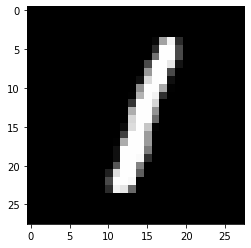

In [10]:
import random
pixels = testX[random.randint(0,len(testX)-1)]
pixels = np.expand_dims(pixels, axis=0)
pyplot.imshow(pixels.reshape(28,28),cmap='gray')
prediction = model.predict(pixels)
index = np.argmax(prediction[0])
print("predicted value is "+str(index))

In [11]:
# 保存模型
model.save('model.h5')

In [12]:
import tensorflow as tf
new_model = tf.keras.models.load_model('model.h5')

predicted value is 6 1.0


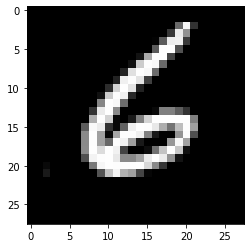

In [26]:
import random
import copy
pixels = testX[random.randint(0,len(testX)-1)]
pixels = np.expand_dims(pixels, axis=0)
pyplot.imshow(pixels.reshape(28,28), cmap='gray')
pixels = pixels.reshape(-1,28,28,1)

prediction = new_model.predict(pixels)
index = np.argmax(prediction[0])
print("predicted value is "+str(index), prediction[0][index])